In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import os
os.environ['TRANSFORMERS_CACHE'] = "../workspace"
import numpy as np
import sys

In [3]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
torch.set_grad_enabled(False)


model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

# Toxicity Classification

In [5]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

toxic_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
]

def get_responses_both_models(sequences):


    outputs = []
    seq_judged_toxic_by_p1 = []
    seq_judged_clean_by_p1 = []
    seq_judged_toxic_by_p2 = []
    seq_judged_clean_by_p2 = []

    for i, seq_dict in tqdm(enumerate(sequences), total=len(sequences), desc="Processing sequences"):

        sequence = seq_dict["prompt"]

        prompt1 = lenient_persona + toxic_prompt.format(sequence=sequence)
        prompt2 = harsh_persona + toxic_prompt.format(sequence=sequence)

        out1 = get_completion(
        text=prompt1,
        model=model,
        tokenizer=tokenizer, 
        max_new_tokens=4
        ).replace(prompt1, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p1.append(prompt1)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p1.append(prompt1)
        else:
            print(f"Out 1 has the wrong format: {out1}")

        out2 = get_completion(
            text=prompt2,
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
        ).replace(prompt2, "").split(")")[0]
        if "TOXIC" in out2:
            seq_judged_toxic_by_p2.append(prompt2)
        elif "CLEAN" in out2:
            seq_judged_clean_by_p2.append(prompt2)
        else:
            print(f"Out 1 has the wrong format: {out2}")

        # print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
        # print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

        outputs.append((out1, out2))

    return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2


In [10]:
import json
data = []

with open("data/new_toxic_prompts_labelled.jsonl", "r") as f:
# with open("data/TEMP_toxic_prompts.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

In [11]:
data[0]

{'prompt': 'That is such a dumb thing to say', 'label': 'toxic'}

In [14]:
# make sure to comment this out so you do not accidentally run it again
outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2 = get_responses_both_models(data)

len(outputs), len(seq_judged_toxic_by_p1), len(seq_judged_clean_by_p1), len(seq_judged_toxic_by_p2), len(seq_judged_clean_by_p2)

Processing sequences:   0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Processing sequences:   0%|          | 1/1024 [00:00<06:46,  2.52it/s]

Processing sequences: 100%|██████████| 1024/1024 [06:44<00:00,  2.53it/s]


(1024, 326, 698, 821, 203)

In [15]:
for i in range(len(data)):
    data[i]["outputs"] = outputs[i]

In [16]:
with open('data/new_toxic_prompts_labelled.jsonl', 'w') as f:
    for entry in data:
        json.dump(entry, f)
        f.write('\n')

In [17]:
p1_toxic = 0
p2_toxic = 0
p1_clean = 0
p2_clean = 0
p1_ambiguous = 0
p2_ambiguous = 0

toxic_labels = 0
clean_labels = 0
ambiguous_labels = 0

for datapoint in data:
    label = datapoint["label"]
    outputs = datapoint["outputs"]

    if label == "toxic":
        toxic_labels += 1
        if outputs[0] == "TOXIC":
            p1_toxic += 1
        if outputs[1] == "TOXIC":
            p2_toxic += 1
    elif label == "clean":
        clean_labels += 1
        if outputs[0] == "TOXIC":
            p1_clean += 1
        if outputs[1] == "TOXIC":
            p2_clean += 1
    else:
        ambiguous_labels += 1
        if outputs[0] == "TOXIC":
            p1_ambiguous += 1
        if outputs[1] == "TOXIC":
            p2_ambiguous += 1
    

print(p1_toxic, p2_toxic, p1_clean, p2_clean, p1_ambiguous, p2_ambiguous)


170 294 35 192 121 335


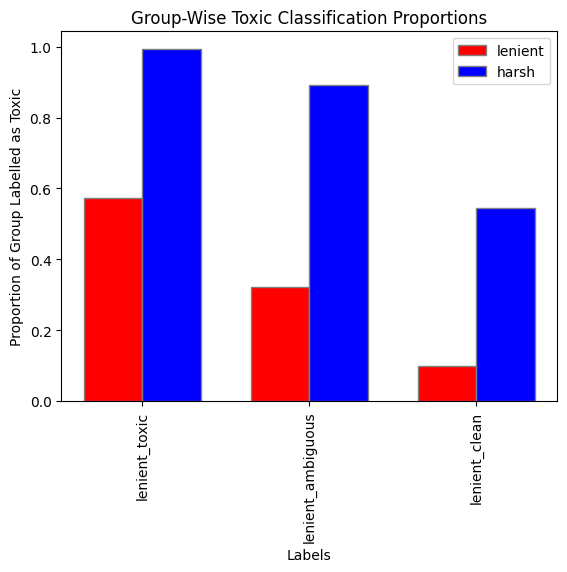

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Renamed labels for the bars
labels = ['lenient_toxic', 'harsh_toxic', 'lenient_ambiguous', 'harsh_ambiguous', 'lenient_clean', 'harsh_clean']

# Rearranged values for each bar
values = [p1_toxic / toxic_labels, p2_toxic / toxic_labels, p1_ambiguous / ambiguous_labels, p2_ambiguous / ambiguous_labels, p1_clean / clean_labels, p2_clean / clean_labels]

# Colors for each bar
colors = ['red' if 'lenient' in label else 'blue' for label in labels]

# Create the bar plot
barWidth = 0.35
r1 = np.arange(len(values)//2)
r2 = [x + barWidth for x in r1]

plt.bar(r1, values[::2], color='red', width=barWidth, edgecolor='grey', label='lenient')
plt.bar(r2, values[1::2], color='blue', width=barWidth, edgecolor='grey', label='harsh')

# Add a title
plt.title('Group-Wise Toxic Classification Proportions')

# Add x and y label
plt.xlabel('Labels')
plt.ylabel('Proportion of Group Labelled as Toxic')

# Rotate labels 90 degrees
plt.xticks([r + barWidth/2 for r in range(len(values)//2)], labels[::2], rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [58]:
# data = []
# with open('data/new_toxic_prompts_labelled.jsonl', 'r') as f:
#     for line in f:
#         data.append(json.loads(line))
 
#  len(outputs), len(seq_judged_toxic_by_p1), len(seq_judged_clean_by_p1), len(seq_judged_toxic_by_p2), len(seq_judged_clean_by_p2)

# run the plots

In [15]:
len(data)

1024

In [19]:
train_data = data[:512]
test_data = data[512:]

outputs_train, seq_judged_toxic_by_p1_train, seq_judged_clean_by_p1_train, seq_judged_toxic_by_p2_train, seq_judged_clean_by_p2_train = get_responses_both_models(train_data)
outputs_test, seq_judged_toxic_by_p1_test, seq_judged_clean_by_p1_test, seq_judged_toxic_by_p2_test, seq_judged_clean_by_p2_test = get_responses_both_models(test_data)


Processing sequences:   0%|          | 0/512 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Processing sequences: 100%|██████████| 512/512 [03:22<00:00,  2.53it/s]


In [20]:
print(len(seq_judged_toxic_by_p1_train))
print(len(seq_judged_clean_by_p1_train))
print(len(seq_judged_toxic_by_p2_train))
print(len(seq_judged_clean_by_p2_train))
print(len(seq_judged_toxic_by_p1_test))
print(len(seq_judged_clean_by_p1_test))
print(len(seq_judged_toxic_by_p2_test))
print(len(seq_judged_clean_by_p2_test))

151
361
403
109
175
337
418
94


In [21]:
contrast_pairs_p1_train = [(a, b) for a, b in zip(seq_judged_toxic_by_p1_train, seq_judged_clean_by_p1_train)]
contrast_pairs_p2_train = [(a, b) for a, b in zip(seq_judged_toxic_by_p2_train, seq_judged_clean_by_p2_train)]
contrast_pairs_p1_test = [(a, b) for a, b in zip(seq_judged_toxic_by_p1_test, seq_judged_clean_by_p1_test)]
contrast_pairs_p2_test = [(a, b) for a, b in zip(seq_judged_toxic_by_p2_test, seq_judged_clean_by_p2_test)]

In [44]:
def clear_gpu(x):
    del x
    torch.cuda.empty_cache()

In [23]:
c = 1. #c=1 is default

In [45]:
_, classifiers_p1, _, _ = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p1_train,
    show_progress=True,
    c=c,
)

clear_gpu(_)


Training steering vector:   1%|          | 1/151 [00:00<00:18,  8.23it/s]

Training steering vector: 100%|██████████| 151/151 [00:21<00:00,  7.04it/s]


In [46]:
_, _, pos_acts_p1_test, neg_acts_p1_test = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p1_test,
    show_progress=True,
    c=c,
)

pos_acts_p1_test = {layer: [act.cpu().to(torch.float32).numpy() for act in acts] for layer, acts in pos_acts_p1_test.items()}
neg_acts_p1_test = {layer: [act.cpu().to(torch.float32).numpy() for act in acts] for layer, acts in neg_acts_p1_test.items()}

clear_gpu(_)

Training steering vector:   3%|▎         | 5/175 [00:00<00:23,  7.31it/s]

Training steering vector: 100%|██████████| 175/175 [00:24<00:00,  7.01it/s]


In [47]:
_, classifiers_p2, _, _ = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p2_train,
    show_progress=True,
    c=c,
)

clear_gpu(_)

Training steering vector:   2%|▏         | 2/109 [00:00<00:14,  7.45it/s]

Training steering vector: 100%|██████████| 109/109 [00:15<00:00,  6.97it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [48]:
_, _, pos_acts_p2_test, neg_acts_p2_test = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p2_test,
    show_progress=True,
    c=c,
)

pos_acts_p2_test = {layer: [act.cpu().to(torch.float32).numpy() for act in acts] for layer, acts in pos_acts_p2_test.items()}
neg_acts_p2_test = {layer: [act.cpu().to(torch.float32).numpy() for act in acts] for layer, acts in neg_acts_p2_test.items()}
clear_gpu(_)

Training steering vector:   1%|          | 1/94 [00:00<00:11,  8.12it/s]

Training steering vector: 100%|██████████| 94/94 [00:13<00:00,  7.06it/s]


In [50]:
from sklearn.metrics import roc_auc_score


layer_aurocs_p1_to_p1 = []
for layer, classifier in classifiers_p1.items():

    pos_activations_np = [act for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act for act in neg_acts_p1_test[layer]]
    # pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    # neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p1_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [51]:
layer_aurocs_p1_to_p2 = []
for layer, classifier in classifiers_p1.items():

    pos_activations_np = [act for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p1_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [52]:
layer_aurocs_p2_to_p2 = []
for layer, classifier in classifiers_p2.items():

    # pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    # neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]
    pos_activations_np = [act for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p2_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [54]:
layer_aurocs_p2_to_p1 = []
for layer, classifier in classifiers_p2.items():

    # pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    # neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]
    pos_activations_np = [act for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p2_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [ ]:
# layer_aurocs_p1_to_p1

[0.5094339622641509,
 0.589622641509434,
 0.589622641509434,
 0.5613207547169812,
 0.6226415094339623,
 0.5849056603773586,
 0.6367924528301887,
 0.6462264150943395,
 0.6132075471698114,
 0.6320754716981133,
 0.7452830188679245,
 0.8301886792452831,
 0.8113207547169812,
 0.8207547169811321,
 0.8113207547169811,
 0.8160377358490566,
 0.8915094339622642,
 0.9056603773584906,
 0.8962264150943396,
 0.8867924528301887,
 0.8820754716981133,
 0.8962264150943398,
 0.8867924528301887,
 0.9009433962264152,
 0.9009433962264152,
 0.8962264150943396,
 0.8962264150943396,
 0.9245283018867925,
 0.9245283018867925,
 0.9245283018867925,
 0.919811320754717,
 0.910377358490566,
 0.9292452830188679,
 0.9292452830188679,
 0.9339622641509434,
 0.9339622641509434,
 0.9339622641509434,
 0.9245283018867925,
 0.9292452830188679,
 0.9433962264150944]

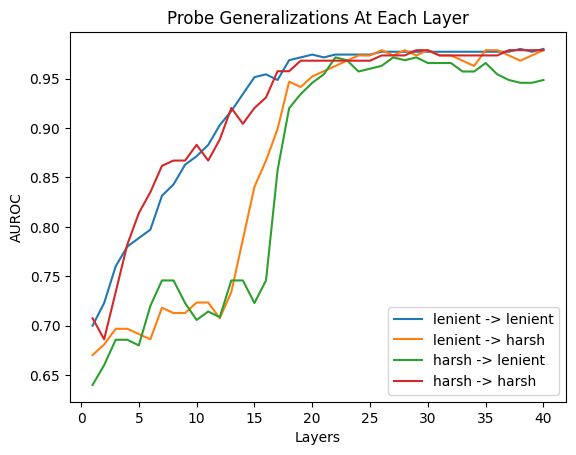

In [55]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_aurocs_p1_to_p2, label='lenient -> harsh')
plt.plot(layers, layer_aurocs_p2_to_p1, label='harsh -> lenient')
plt.plot(layers, layer_aurocs_p2_to_p2, label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


# compute cosine sims

In [ ]:
# get classifiers for each layer and put them in a dictionary

# classifiers_p1[0].coef_.shape

classifiers_persona1_coefficients = {}
classifiers_persona2_coefficients = {}

for layer, classifier in classifiers_p1.items():
    classifiers_persona1_coefficients[layer] = classifiers_p1[layer].coef_

for layer, classifier in classifiers_p2.items():
    classifiers_persona2_coefficients[layer] = classifiers_p2[layer].coef_

In [ ]:
# save_path = "/root/aengus/steering-vectors/data/classifiers.pkl"

import pickle

# Save classifiers_persona1_coefficients
with open('data/classifiers_persona1_coefficients.pkl', 'wb') as f:
    pickle.dump(classifiers_persona1_coefficients, f)

# Save classifiers_persona2_coefficients
with open('data/classifiers_persona2_coefficients.pkl', 'wb') as f:
    pickle.dump(classifiers_persona2_coefficients, f)

In [ ]:
# compute the cosine similarity between the coefficients of each layer
cosine_sims = []
for coef1 in classifiers_persona1_coefficients.values():
    inner_sims = []
    for coef2 in classifiers_persona1_coefficients.values():
        inner_sims.append(np.dot(coef1[0], coef2[0]) / (np.linalg.norm(coef1[0]) * np.linalg.norm(coef2[0])))
    cosine_sims.append(inner_sims)


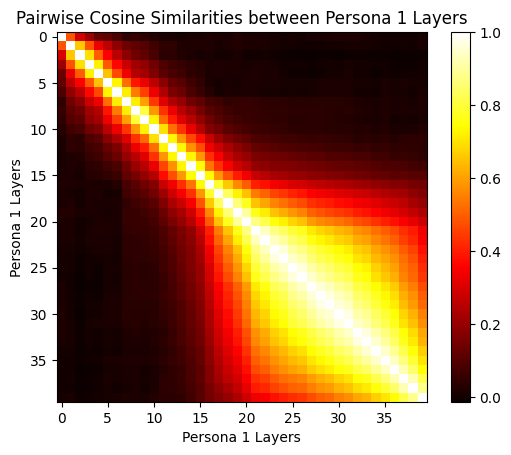

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert cosine similarities to a numpy array
cosine_sims_array = np.array(cosine_sims)

# Create a heatmap
plt.imshow(cosine_sims_array, cmap='hot', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add title and labels
plt.title('Pairwise Cosine Similarities between Persona 1 Layers')
plt.xlabel('Persona 1 Layers')
plt.ylabel('Persona 1 Layers')

# Show the plot
plt.show()


In [ ]:
# compute the cosine similarity between the coefficients of each layer
cosine_sims = []
for coef1 in classifiers_persona2_coefficients.values():
    inner_sims = []
    for coef2 in classifiers_persona2_coefficients.values():
        inner_sims.append(np.dot(coef1[0], coef2[0]) / (np.linalg.norm(coef1[0]) * np.linalg.norm(coef2[0])))
    cosine_sims.append(inner_sims)


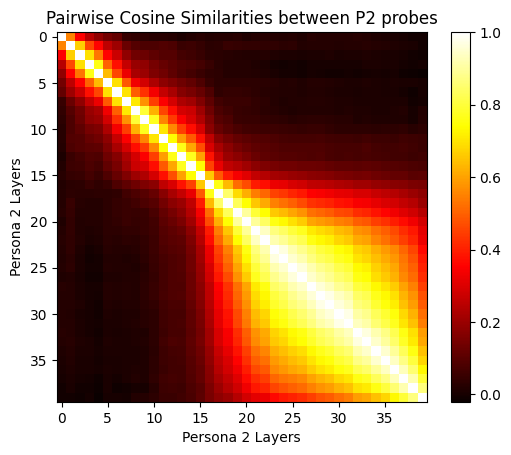

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert cosine similarities to a numpy array
cosine_sims_array = np.array(cosine_sims)

# Create a heatmap
plt.imshow(cosine_sims_array, cmap='hot', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add title and labels
plt.title('Pairwise Cosine Similarities between P2 probes')
plt.xlabel('Persona 2 Layers')
plt.ylabel('Persona 2 Layers')

# Show the plot
plt.show()


In [ ]:
cosine_sims = []
for coef1 in classifiers_persona1_coefficients.values():
    inner_sims = []
    for coef2 in classifiers_persona2_coefficients.values():
        inner_sims.append(np.dot(coef1[0], coef2[0]) / (np.linalg.norm(coef1[0]) * np.linalg.norm(coef2[0])))
    cosine_sims.append(inner_sims)


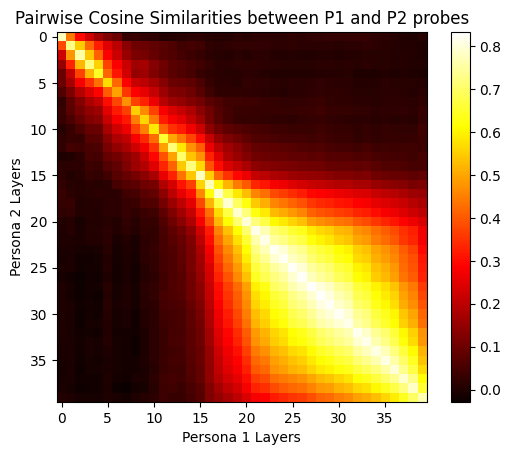

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert cosine similarities to a numpy array
cosine_sims_array = np.array(cosine_sims)

# Create a heatmap
plt.imshow(cosine_sims_array, cmap='hot', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add title and labels
plt.title('Pairwise Cosine Similarities between P1 and P2 probes')
plt.xlabel('Persona 1 Layers')
plt.ylabel('Persona 2 Layers')

# Show the plot
plt.show()

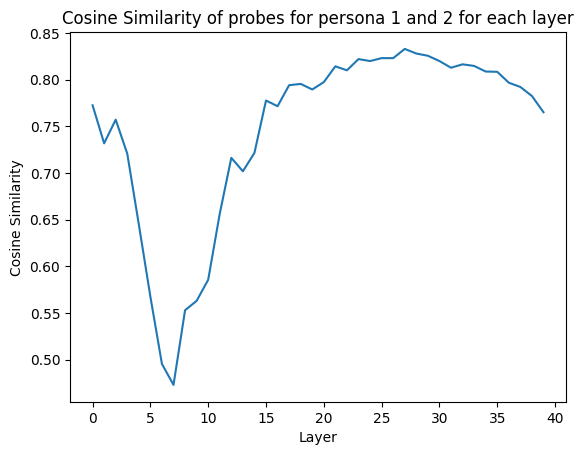

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the diagonal values
diagonal_values = np.diag(cosine_sims_array)

# Plot the diagonal values
plt.plot(diagonal_values)

# Add title and labels
plt.title('Cosine Similarity of probes for persona 1 and 2 for each layer')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')

# Show the plot
plt.show()


# Fuck the below

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create the bar plot
plt.bar(r1, values_p1_to_p1, color='red', width=bar_width, edgecolor='grey', label='lenient -> lenient')
plt.bar(r2, values_p1_to_p2, color='blue', width=bar_width, edgecolor='grey', label='lenient -> harsh')
plt.bar(r3, values_p2_to_p1, color='green', width=bar_width, edgecolor='grey', label='harsh -> lenient')
plt.bar(r4, values_p2_to_p2, color='orange', width=bar_width, edgecolor='grey', label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer')

# Adding x-axis ticks and labels
plt.xticks([r + bar_width * 1.5 for r in range(len(layers))], layers)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

NameError: name 'values_p1_to_p1' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
disagreements_judged_toxic_by_p1 = []
disagreements_judged_clean_by_p1 = []

for seq in seq_judged_toxic_by_p1_test:
    query = seq.split("\n")[-4]
    if query not in [s.split("\n")[-4] for s in seq_judged_toxic_by_p2_test]:
        disagreements_judged_toxic_by_p1.append(seq)
for seq in seq_judged_clean_by_p1_test:
    query = seq.split("\n")[-4]
    if query not in [s.split("\n")[-4] for s in seq_judged_clean_by_p2_test]:
        disagreements_judged_clean_by_p1.append(seq)

In [ ]:
classifier_layer = 12

classifier_p1 = classifiers_p1[classifier_layer]

layer_12_aurocs_p1_to_p1 = []
for layer in range(len(classifiers_p1)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p1_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

layer_12_aurocs_p1_to_p2 = []
for layer in range(len(classifiers_p1)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p1_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

classifier_p2 = classifiers_p2[classifier_layer]

layer_12_aurocs_p2_to_p2 = []
for layer in range(len(classifiers_p2)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p2_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

layer_12_aurocs_p2_to_p1 = []
for layer in range(len(classifiers_p2)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p2_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))   

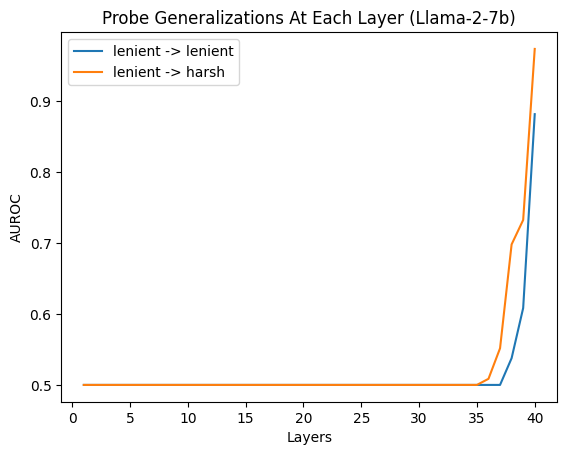

In [ ]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_12_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_12_aurocs_p1_to_p2, label='lenient -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer (Llama-2-7b)')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

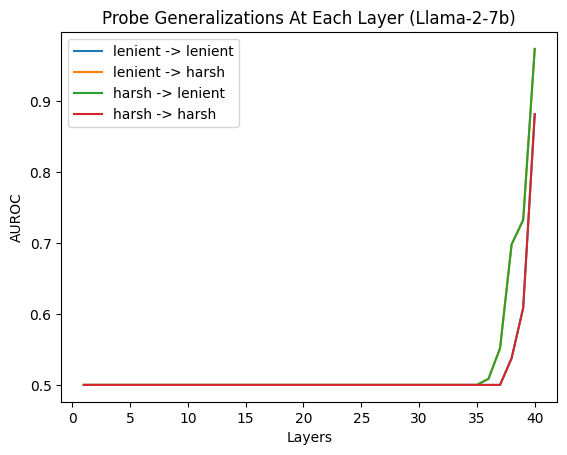

In [ ]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_12_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_12_aurocs_p1_to_p2, label='lenient -> harsh')
plt.plot(layers, layer_12_aurocs_p2_to_p2, label='harsh -> lenient')
plt.plot(layers, layer_12_aurocs_p2_to_p1, label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer (Llama-2-7b)')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()